# Dimensionality Reduction - Practical Application

This notebook is following the progression of the Dimensionality Reduction class. It provides practical illustrations in Python  to understand the notions we have seen in this course.

<div class="alert alert-warning">
Author: Fabrice JIMENEZ
    
Link to course materials: https://github.com/jfabrice/ml-class-dimensionality-reduction
</div>

## Preliminary loading with Google Colab

If you are using this notebook with Google Colab, please execute first the following cells, to retrieve the GitHub repository content and set the working directory. Otherwise, ignore these 2 cells and move to the next section.

In [ ]:
!git clone https://github.com/jfabrice/ml-class-dimensionality-reduction.git

In [ ]:
import os
os.chdir('ml-class-dimensionality-reduction')

## Imports and Loading Dataset

The dataset we will use for this application is the famous MNIST dataset (handwritten digits). We use the CSV version of this dataset available here: https://pjreddie.com/projects/mnist-in-csv/ 

We will keep only the mnist_test.csv file, containing 10 000 gray-scale images of dimension 28 x 28.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/mnist_test.csv', header=None)
df['pixels'] = df.index.map(lambda x: np.array(df.iloc[x][1:]))
dropcols = df.columns[(df.columns != 0) * (df.columns != 'pixels')]
df.drop(dropcols, axis=1, inplace=True)
df.columns = ['label','pixels']
print(df.shape)

(10000, 2)


In [3]:
df.head()

,label,pixels
0,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


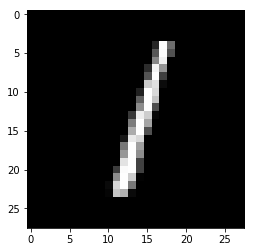

In [4]:
fig = plt.imshow(df['pixels'][2].reshape(28,28), cmap='gray')

## Dimensionality reduction

In this section we will think about how to distinguish the characteristics of different handwritten digits, starting only from the raw values of the pixels as features.

Let's consider 3 digits. Keep them as they are for the moment, you will have time at the end to play with these parameters.

In [5]:
## Digits considered here ##
labels = [1,6,8]
colors = ['red', 'blue', 'green']

X = np.array([df['pixels'][i] for i in df.index if df['label'][i] in labels])
y = np.array([df['label'][i] for i in df.index if df['label'][i] in labels])

print('X shape: '+str(X.shape))
print('y shape: '+str(y.shape))

X shape: (3067, 784)
y shape: (3067,)


We have 28 x 28 = 784 features. It is a high dimension (~ same order of magnitude as the number of points). 

<div class="alert alert-warning">
Question: How would you visualize the behavior of the different classes (digits), or find a direction, important features contributing to these classes?
</div>

In this case, we cannot rely on univariate analysis: it is quite clear that the value of a given pixel on the image will not determine by itself the number which is written. You need to study the relationship between the pixel values: let's see how the methods to reduce dimensionality we saw during this course can help us distinguish noise, correlation and information patterns!

#### Principal Components Analysis: linear approach

In [6]:
from sklearn.decomposition import PCA

In [7]:
## Computing the PCA
pca = PCA(n_components=X.shape[1])
XPCA = pca.fit_transform(X)

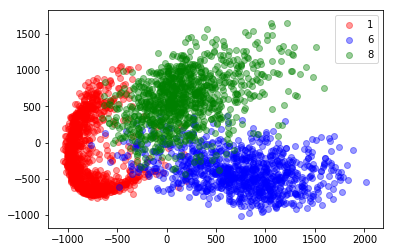

In [8]:
## Choose the axes you want to visualize
component_x = 1
component_y = 2

## Plotting
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.scatter(XPCA[y == labels[i],component_x-1], XPCA[y == labels[i],component_y-1], c=colors[i], label=labels[i], alpha=0.4)

l = ax.legend()

<div class="alert alert-warning">
Question: Try to visualize different axes and find the ones who allow (or not) to distinguish the classes.
</div>

#### t-distributed Stochastic Neighbor Embedding: non-linear approach

In [9]:
from sklearn.manifold import TSNE

In [10]:
## Computing the t-SNE 2D projection

## Parameters with real influence on the accuracy
perplexity = 30
learning_rate = 200
n_iter = 1000

tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
XTSNE = tsne.fit_transform(X)

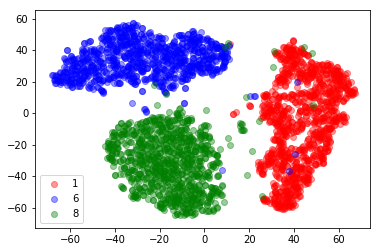

In [11]:
## Plotting
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.scatter(XTSNE[y == labels[i],0], XTSNE[y == labels[i],1], c=colors[i], label=labels[i], alpha=0.4)
l = ax.legend()

<div class="alert alert-warning">
Question: Try to visualize the projection by choosing different parameter values. What is the advantage of t-SNE over PCA? What is the inconvenient?
</div>

## Impact on supervised model performance

In this section, we consider a supervised Machine Learning model to predict the class of an image (which digit it corresponds to). We will study the impact of dimensionality reduction on 3 classifiers which have different mechanisms:
- Naive Bayes Classifier (nb)
- SVM Classifier (svm)
- Random Forest Classifier (rf)

We can give them as features 3 different inputs:
- All the pixel values (raw)
- The n first PCA components (10 for example)
- The 2 dimensions from t-SNE projection (tsne)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [13]:
def fit_my_model(model, features, test_size):
    
    ## Building train and test sets from features
    if features == 'raw':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    elif features == 'tsne':
        X_train, X_test, y_train, y_test = train_test_split(XTSNE, y, test_size=test_size)
    else:
        X_train, X_test, y_train, y_test = train_test_split(XPCA[:,:features], y, test_size=test_size)

    print("Training samples: "+str(X_train.shape[0]))
    print("Testing samples: "+str(X_test.shape[0]))
    print("Number of features: "+str(X_train.shape[1]))
    
    ## Fitting model
    if model == 'nb':
        clf = GaussianNB()
    elif model == 'svm':
        clf = SVC(gamma='auto')
    elif model == 'rf':
        clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features=np.min([10, X_train.shape[1]]))

    clf.fit(X_train, y_train)
    
    ## Printing scores
    learningScore = clf.score(X_train, y_train)
    generalizationScore = clf.score(X_test, y_test)
    print('Learning score: '+str(learningScore))
    print('Generalization score: '+str(generalizationScore))
    
    return generalizationScore

<div class="alert alert-warning">
Question: Experiment in the cell below by using the function fit_my_model, to check the scores for different configurations
</div>

In [14]:
model = 'svm' ## svm, nb, rf
features = 'raw' ## raw, tsne, or Integer corresponding to the n first PCA components
test_size = 0.2

score = fit_my_model(model, features, test_size)

Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.3778501628664495


<div class="alert alert-warning">
Question: What is the effect of dimensionality reduction on the 3 classifiers? Try to explain why with your intuition...
</div>

Let's test all the configurations and build a result table with test scores, to help you answer this question.

In [15]:
comparison_table = pd.DataFrame(columns = ['raw', 'pca', 'tsne'], index=['svm', 'nb', 'rf'])
for f in comparison_table.columns:
    for m in comparison_table.index:
        print(f + ' - ' + m)
        comparison_table.loc[m,f] = fit_my_model(m, f if f!='pca' else 10, 0.2)

raw - svm
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.33876221498371334
raw - nb
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 0.9188748471259682
Generalization score: 0.8990228013029316
raw - rf
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.9837133550488599
pca - svm
Training samples: 2453
Testing samples: 614
Number of features: 10
Learning score: 1.0
Generalization score: 0.3469055374592834
pca - nb
Training samples: 2453
Testing samples: 614
Number of features: 10
Learning score: 0.953118630248675
Generalization score: 0.9657980456026058
pca - rf
Training samples: 2453
Testing samples: 614
Number of features: 10
Learning score: 1.0
Generalization score: 0.9739413680781759
tsne - svm
Training samples: 2453
Testing samples: 614
Number of features: 2
Learning score: 0.9987770077456176
Generalization score: 0.9902280

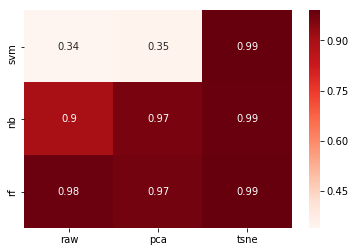

In [16]:
## Heatmap with summarized results
fig = sns.heatmap(comparison_table.astype('float'), annot=True, cmap='Reds')

<div class="alert alert-warning">
Question: What conclusions can you give? If you have time left, you can try with different sets of digits.
</div>

These examples concern supervised classifiers only. Can you imagine the impact on other tasks: regression, clustering, anomaly detection... ?

## Conclusion

Always think first about the principles, the intuition, the qualitative aspect behind all the available functions you can find online.

- Many people can chain very complex algorithms together and get results which might be relevant for a problem.
- Only a few can make the right choices to quickly optimize the resolution of a problem and assess its feasability...